# Load 2K to test effectiveness

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
debug_mode=1 # if not in debug mode, please set debug_mode=0, find more info about debug mode in test run 9 maybe?
%load_ext autoreload
%autoreload 2
%matplotlib inline

## I. Background
### A. Preprocessing the Corpus and Save to the Database (Done)

The corpus could be downloaded [here](https://github.com/xeniaqian94/snorkel/blob/master/abstractnet/testrun/data/slim-slim-top-tier-citation).

In [2]:
import os
os.environ['SNORKELDB'] = "postgresql:///abstractnet2k"
print(os.environ['SNORKELDB'])
from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor
session = SnorkelSession()

## Here, we just set the upperbound for how many documents we'll process!
n_docs = 3000 
doc_preprocessor = TSVDocPreprocessor('data/annotations_label-level_all-to-date-2018-4-25-WithTitle_full_abstract_punc_concatenated.csv', encoding="utf-8",max_docs=n_docs)

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

# corpus_parser = CorpusParser(parser=Spacy())
# %time corpus_parser.apply(doc_preprocessor, count=n_docs)# ,parallelism=5)

from snorkel.models import Document, Sentence  # defined in context.py file
print("Documents:", session.query(Document).count())

postgresql:///abstractnet2k
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True


/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Documents: 2050


### B. Connect to the Database and retrieve Document

Recall the Document/Sentence/Candidate hierarchy in the guideline. We also divide the whole document set into buckets of each 100 documents.

In [3]:
from snorkel import SnorkelSession
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence
from collections import defaultdict
import numpy as np

session = SnorkelSession()
docs = session.query(Document).all()
sents = session.query(Sentence).all()  # get all sentences from snorkel.db

docs_per_bucket=105
sents_split=defaultdict(lambda:[])
for ind, doc in enumerate(docs):
    bucket=int(ind/docs_per_bucket)
    for s in doc.sentences:
        sents_split[bucket]+=[s]
print("Number of buckets", len(sents_split))

Number of buckets 20


### C. From Documents to Extract Candidates

Here we extract the candidates (i.e. unigrams) from one of the document bucket, which has approximately 100 documents. Here we use <b>Bucket 0</b>. So it is our train bucket to learn the generative model from LFs. Later we will use <b>Bucket 1</b> as the development bucket, to draw visualizations and provide feedbacks. 

In [4]:
from snorkel.models import candidate_subclass
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import *
import datetime

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Unigram = candidate_subclass('Unigram', ['unigram_cue'],values=['PP','MN','NULL'])
ngrams = Ngrams(n_max=1) 
ngram_matcher=NgramMatcher()
unigram_segment_extractor=CandidateExtractor(Unigram,[ngrams],[ngram_matcher])

train_bucket=0
# %time unigram_segment_extractor.apply(sents_split[train_bucket], split=train_bucket)
unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
print("Number of Candidates/Unigrams",len(unigram_segments))

Number of Candidates/Unigrams 17943


### D. Data Exploration 

Let's visualize some Candidates/Unigrams with SentenceNgramViewer. 

In [5]:
from snorkel.viewer import SentenceNgramViewer

unigram_segments=session.query(Unigram).filter(Unigram.split == train_bucket).all()
SentenceNgramViewer(unigram_segments[0:100], session, n_per_page=10)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0, 6, 10, 12, 16, 22, 24, 26, 32, 34, 38, 39, 43, 47, 49, 55], [1, 4, 8, 11, 17, 1…

## II. Labeling Functions
### A. Load the n-th version of LFs

In this n-th version, a majority of our LFs are cue-based LFs. You can tell from the names!

In [8]:
from snorkel.lf_helpers import *
from snorkel.annotations import LabelAnnotator

# from LF.util_common_default_categorical import purpose_LFs,mechanism_LFs,null_LFs
from LF.util_common_default_categorical_1023 import purpose_LFs,mechanism_LFs,null_LFs
print("total LF count", len(purpose_LFs+mechanism_LFs+null_LFs), "unique count",len(set(purpose_LFs+mechanism_LFs+null_LFs)),"purpose_LFs",len(purpose_LFs),"mechanism_LFs",len(mechanism_LFs))
print("\n\npurpose_LFs\n",[lf.__name__ for lf in purpose_LFs])
print("\n\nmechanism_LFs\n",[lf.__name__ for lf in mechanism_LFs])
print("\n\nnull_LFs\n",[lf.__name__ for lf in null_LFs])

2050it [00:00, 22064.41it/s]
313it [00:00, 3128.31it/s]

Loading GloVe embedding


400000it [00:15, 25918.54it/s]


GloVe embedding loaded
total LF count 141 unique count 141 purpose_LFs 36 mechanism_LFs 21


purpose_LFs
 ['LF_purpose_goal3_True', 'LF_purpose_goalneg2_True', 'LF_purpose_the_problem_of3_True', 'LF_purpose_the_problem_ofneg2_True', 'LF_purpose_the_task_of3_True', 'LF_purpose_the_task_ofneg2_True', 'LF_purpose_useful_to3_True', 'LF_purpose_useful_toneg2_True', 'LF_purpose_whether3_True', 'LF_purpose_whetherneg2_True', 'LF_purpose_in_order_to3_True', 'LF_purpose_in_order_toneg2_True', 'LF_purpose_ways_to3_True', 'LF_purpose_ways_toneg2_True', 'LF_purpose_lemma_understand3_True', 'LF_purpose_lemma_understandneg2_True', 'LF_purpose_lemma_answer3_True', 'LF_purpose_lemma_answerneg2_True', 'LF_purpose_lemma_crucial3_True', 'LF_purpose_lemma_crucialneg2_True', 'LF_purpose_lemma_issue3_True', 'LF_purpose_lemma_issueneg2_True', 'LF_purpose_lemma_allow3_True', 'LF_purpose_lemma_allowneg2_True', 'LF_purpose_lemma_investigate3_True', 'LF_purpose_lemma_investigateneg2_True', 'LF_purpose_lemma_stud

## VI. Development Sandbox
### A. Writing New Labeling Functions

We will name them as `new_LFs`.

In [9]:
#
# PLACE YOUR LFs HERE
#
new_LFs=[]

### B. Applying Labeling Functions

In here we define two functions: (1) applying LFs to get an annotation matrix; (2) use the annotation matrix to learn a generative model.

In [10]:
from snorkel.learning import GenerativeModel
from util import get_candidate_text
import matplotlib.pyplot as plt
import datetime

def get_L_train(LFs,parallelism=1,split=0):
    L_train=None
    labeler=None
    np.random.seed(1701)
    labeler = LabelAnnotator(lfs=LFs)
    print(datetime.datetime.now())
    L_train = labeler.apply(split=split,parallelism=parallelism)# ,cids_query=session.query(Candidate.id).filter(Candidate.get_parent().id %10==1))
    print(datetime.datetime.now())
    print(type(L_train))
    print(L_train.shape)
    printmd("**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  "+str(L_train.non_overlapping_coverage()))
    return L_train

def get_train_marginals(L_train,step_size_nominator=0.1,epochs=100,lf_propensity=True,threads=1,class_prior=False,decay=1.0,reg_param=1e-6):
    try:
        gen_model=None
        print(datetime.datetime.now())
        gen_model = GenerativeModel(lf_propensity=lf_propensity,class_prior=class_prior)
        gen_model.train(L_train, cardinality=3, epochs=epochs, decay=decay,step_size=step_size_nominator/1e2,reg_param=reg_param,verbose=False,threads=threads)
        print("training finished ")
        print(datetime.datetime.now())
        print("Finished training generative model, now checking performance against development set labels...")
        print("Calculating marginals!")
        train_marginals = gen_model.marginals(L_train)  # the marginal probability of each candidate being True
        print("no exception")
        print(datetime.datetime.now())
        return gen_model,train_marginals
    except:
        print("exception! ")
        return gen_model,train_marginals


In [11]:
L_train=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs)
print(L_train.shape)

snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-23 23:48:21.281785
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 17943
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-23 23:51:27.209010
<class 'snorkel.annotations.csr_LabelMatrix'>
(17943, 138)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.4113024577829794

(17943, 138)


In [24]:
# import pandas as pd 
pd.set_option('display.max_rows', 500)

df=L_train.lf_stats(session)
df['Conflict_Coverage_ratio'] = df['Conflicts']/df['Coverage']

df_ratio_added=df.sort_values(by=['Conflict_Coverage_ratio'],ascending=False)

# df_ratio_added[df_ratio_added.index.str.contains("we_similar")]
df_ratio_added


,j,Coverage,Overlaps,Conflicts,Conflict_Coverage_ratio
LF_null_indicates_thatneg2_True,176,0.002229,0.002229,0.002229,1.000000
LF_mechanism_using_a_neg2_True,107,0.003065,0.003065,0.003065,1.000000
LF_null_recent_research3_True,187,0.000111,0.000111,0.000111,1.000000
LF_purpose_we_similar_fundamental_neg2_True,73,0.000613,0.000613,0.000613,1.000000
LF_mechanism_using_a_3_True,106,0.000223,0.000223,0.000223,1.000000
LF_null_recentlyneg2_True,186,0.002619,0.002619,0.002619,1.000000
LF_null_recently3_True,185,0.000279,0.000279,0.000279,1.000000
LF_mechanism_employed_neg2_True,103,0.001783,0.001783,0.001783,1.000000
LF_purpose_crucialneg2_True,18,0.001282,0.001282,0.001282,1.000000
LF_purpose_crucial3_True,17,0.000167,0.000167,0.000167,1.000000


,j,Coverage,Overlaps,Conflicts,Conflict_Coverage_ratio
LF_null_indicates_thatneg2_True,176,0.002229,0.002229,0.002229,1.000000
LF_mechanism_using_a_neg2_True,107,0.003065,0.003065,0.003065,1.000000
LF_null_recent_research3_True,187,0.000111,0.000111,0.000111,1.000000
LF_purpose_we_similar_fundamental_neg2_True,73,0.000613,0.000613,0.000613,1.000000
LF_mechanism_using_a_3_True,106,0.000223,0.000223,0.000223,1.000000
LF_null_recentlyneg2_True,186,0.002619,0.002619,0.002619,1.000000
LF_null_recently3_True,185,0.000279,0.000279,0.000279,1.000000
LF_mechanism_employed_neg2_True,103,0.001783,0.001783,0.001783,1.000000
LF_purpose_crucialneg2_True,18,0.001282,0.001282,0.001282,1.000000
LF_purpose_crucial3_True,17,0.000167,0.000167,0.000167,1.000000


In [25]:
for reg_param in [1e-3]:#,1e-6]: #[1e-3, 1e-6]:
    for decay in [0.95]: #[1.0,0.95]:
        for step_size_nominator in [0.01,0.001]: # [0.01, 0.1, 1]:
            for epochs in [2,3,4,5,7]:#,30,50,100,200,500]:
                for lf_propensity in [False]:
                    
                    print("grid search with L_train","step_size_nominator",step_size_nominator,"epochs",epochs,"decay",decay,"reg_param",reg_param,"lf_propensity",lf_propensity)
                    gen_model,train_marginals=get_train_marginals(L_train,threads=18,lf_propensity=lf_propensity,step_size_nominator=step_size_nominator,epochs=epochs,decay=decay,reg_param=reg_param)
                    assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

                    winHighlight=train_marginals.argmax(axis=1)
                    print("PP",(winHighlight==0).sum())
                    print("MN",(winHighlight==1).sum())
                    print("NULL",(winHighlight==2).sum())

                    # Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
                    train_marginals_reverse = train_marginals[:,::-1]
                    winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
                    print("amend PP",(winHighlight==0).sum())
                    print("amend MN",(winHighlight==1).sum())
                    print("amend NULL",(winHighlight==2).sum())


grid search with L_train step_size_nominator 0.01 epochs 2 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-23 22:55:59.384754
Compiles variable matrix
grid search with L_train step_size_nominator 0.01 epochs 2 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-23 22:55:59.384754
Compiles variable matrix
_compile finished!
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-23 22:58:10.239960
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Compiles variable matrix
_compile finished!
training finished 
2018-10-23 22:58:10.239960
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-23 22:58:15.741232
PP 9597
MN 4497
NULL 3849
amend PP 4590
amend MN 4497
amend NULL 8856
grid search with L_train step_size_nominator 0.01 epochs 3 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-23 22:

_compile finished!
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-23 23:19:01.055080
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
Compiles variable matrix
_compile finished!
training finished 
2018-10-23 23:19:01.055080
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-23 23:19:06.121070
PP 9922
MN 4340
NULL 3681
amend PP 4915
amend MN 4340
amend NULL 8688
grid search with L_train step_size_nominator 0.001 epochs 7 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-23 23:19:06.126526
Compiles variable matrix
no exception
2018-10-23 23:19:06.121070
PP 9922
MN 4340
NULL 3681
amend PP 4915
amend MN 4340
amend NULL 8688
grid search with L_train step_size_nominator 0.001 epochs 7 decay 0.95 reg_param 0.001 lf_propensity False
2018-10-23 23:19:06.126526
Compiles variable matrix
_compile

### C. Learning the Generative Model

In [12]:
reg_param=1e-3
decay=0.95
step_size_nominator=0.01
epochs=5
lf_propensity=False
                        
print("train starts here", datetime.datetime.now())
gen_model,train_marginals=get_train_marginals(L_train,threads=18,step_size_nominator=step_size_nominator,lf_propensity=lf_propensity,epochs=epochs,decay=decay,reg_param=reg_param)
assert np.all(train_marginals.sum(axis=1) - np.ones(train_marginals.shape[0]) < 1e-10)

winHighlight=train_marginals.argmax(axis=1)
print("PP",(winHighlight==0).sum())
print("MN",(winHighlight==1).sum())
print("NULL",(winHighlight==2).sum())

# Amendment!!! winning highligh with default as NULL (the last occurence of largest value)
train_marginals_reverse = train_marginals[:,::-1]
winHighlight = train_marginals.shape[1] - np.argmax(train_marginals_reverse,axis=1) - 1
print("amend PP",(winHighlight==0).sum())
print("amend MN",(winHighlight==1).sum())
print("amend NULL",(winHighlight==2).sum())

train starts here 2018-10-24 09:41:23.141895
2018-10-24 09:41:23.144007
Compiles variable matrix
_compile finished!
Compiles variable matrix
_compile finished!
training finished 
2018-10-24 09:43:07.835700
Finished training generative model, now checking performance against development set labels...
Calculating marginals!
no exception
2018-10-24 09:43:13.171995
PP 11454
MN 1431
NULL 5058
amend PP 891
amend MN 1431
amend NULL 15621


### D. Visualize generative labels on this train set, then on the dev set

0
10000
dispatch finished!! 


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0
10000
dispatch finished!! 
0
10000
dispatch finished!! 
0
10000
dispatch finished!! 
0
10000
dispatch finished!! 
0
10000
dispatch finished!! 


<Figure size 432x288 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

<Figure size 2880x504 with 0 Axes>

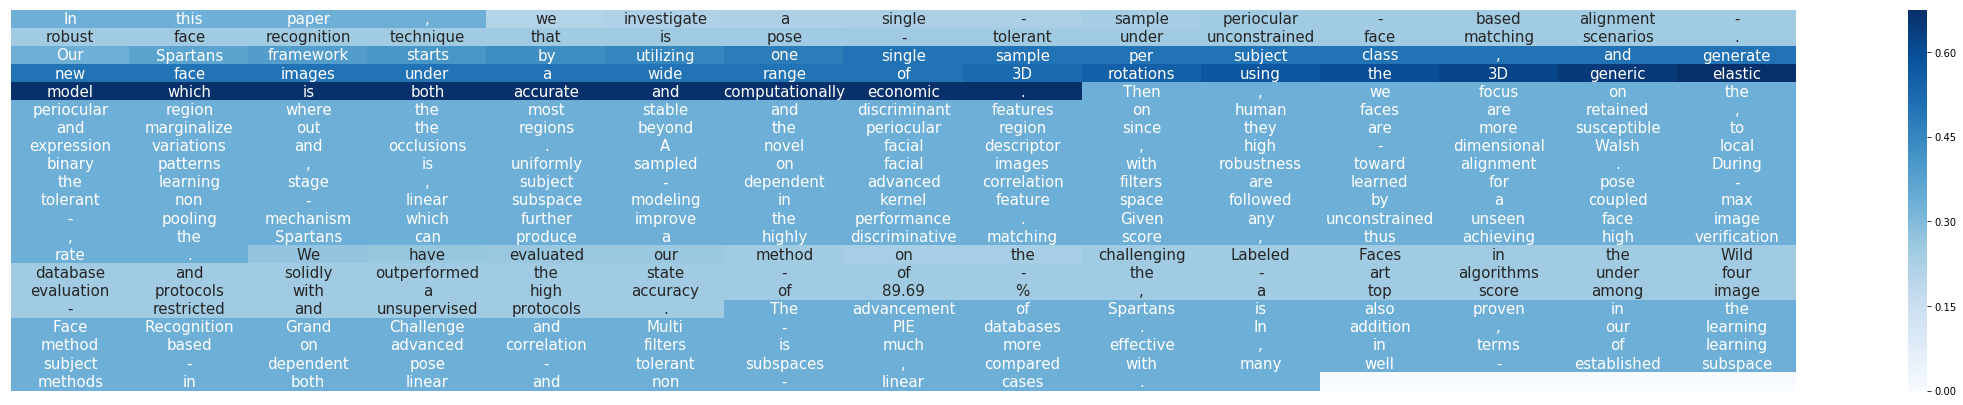

In [13]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd

def pad_reshape(A,width,isFloat=False):
    B=np.empty([1,int(A.shape[1]/width+1)*width],dtype=object)
    if isFloat:
        B=np.zeros([1,int(A.shape[1]/width+1)*width])
        B[:,:A.shape[1]]=A
    else:
        B[:,:A.shape[1]]=A
        B[:,A.shape[1]:]=""
    return B.reshape(-1,width)
 

def create_new_score_array(smooth_window,score_array,word_array):
    new_score_array=np.zeros(score_array.shape)
    half_window=int(smooth_window/2)
    punctuation=[",","."]
    for i in range(score_array.shape[1]):
        sub_score_array=score_array[0,max(0,i-half_window):i+half_window+1]
        sub_word_array=word_array[0,max(0,i-half_window):i+half_window+1]

        mid_pos=half_window

        left_pos=mid_pos
        right_pos=mid_pos
#         print(sub_word_array[left_pos],type(sub_word_array[left_pos]))
        while left_pos>0 and str(sub_word_array[left_pos-1][0]) not in punctuation:
            left_pos-=1
        while right_pos<len(sub_word_array):
            right_pos+=1
            if str(sub_word_array[right_pos-1][0]) in punctuation:
                break
        new_score_array[0,i]=np.mean(sub_score_array[left_pos:right_pos])
    return new_score_array


    
def visualize_word_level(tag,unigram_segments,score_list,directory="data/word_level_tag_visualization",smooth_window=0,cmap="Greens"):
    doc_dict=defaultdict(lambda:[])

    pair_list=list(zip(unigram_segments,score_list))

    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]
    print("dispatch finished!! ")

    for docid in doc_dict:
        plt.clf()
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))
        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        fig, ax = plt.subplots(figsize=(40,7))  
        width=15
        score_array=np.asarray(df[['score']]).reshape(1,-1)
        word_array=np.asarray(df[['word']]).reshape(1,-1)
        
        if smooth_window!=0:
            score_array=create_new_score_array(smooth_window,score_array,word_array)
#             print(new_score_array.shape)
        sns.heatmap(pad_reshape(score_array,width,isFloat=True), cmap=cmap, annot=pad_reshape(word_array,width),fmt='',yticklabels=False,xticklabels=False,ax=ax,annot_kws={"size": 15})
        plt.savefig(os.path.join(directory,"run",docid+"_"+tag))
  
sample_size=train_marginals.shape[0]
# visualize_word_level("PP",unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1))) 
# visualize_word_level("MN",unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)))

smooth_window=3
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")

smooth_window=5
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")

smooth_window=7
visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k") 
visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments[:sample_size],list(train_marginals[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k")



We could now view visualization on this train set back in the directory.

In [31]:
# blind_bucket=1
# %time unigram_segment_extractor.apply(sents_split[blind_bucket], split=blind_bucket)
# unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == blind_bucket).all()

# L_train_tmp=get_L_train(purpose_LFs+mechanism_LFs+null_LFs+new_LFs,split=blind_bucket)
# print("creating blind_marginals")

# train_marginals_tmp = gen_model.marginals(L_train_tmp)
# print("visualizing blind_marginals")
# sample_size=train_marginals_tmp.shape[0]
# smooth_window=3
# visualize_word_level("PP"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,0].reshape(-1)),smooth_window=smooth_window,cmap="Reds",directory="data/word_level_tag_visualization/2k/blind") 
# visualize_word_level("MN"+"_"+str(smooth_window),unigram_segments_tmp[:sample_size],list(train_marginals_tmp[:sample_size,1].reshape(-1)),smooth_window=smooth_window,cmap="Blues",directory="data/word_level_tag_visualization/2k/blind") 

We could now view visualization on this blind set back in the directory. Look for important mismatch between the visualized segmentation and any missed LFs.

In [16]:
def get_candidate_text(segment):
    return segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1]

def write_csv_gen_label(unigram_segments,train_marginals,csv_path,smooth_window=3):
    
    pair_list=list(zip(unigram_segments,train_marginals))
    new_unigram_segments=[]
    new_train_marginals=[]
    doc_dict=defaultdict(lambda:[])
    for ind,pair in enumerate(pair_list):
        if ind%10000==0:
            print(ind)
        docid=pair[0].get_parent().get_parent().name
        doc_dict[docid]+=[pair]

    for docid in doc_dict:
        doc_dict[docid]=sorted(doc_dict[docid], key=lambda pair: (pair[0].get_parent().position, pair[0].get_contexts()[0].get_word_start()))

        ordered_word_score_list=[(pair[0].get_parent().text[pair[0].unigram_cue.char_start:pair[0].unigram_cue.char_end+1], pair[1]) for pair in doc_dict[docid]]
        df=pd.DataFrame.from_records(ordered_word_score_list,columns=['word','score'])
        score_array=np.asarray(df[['score']]).reshape(1,-1)
        new_train_marginals_array=np.zeros([len(doc_dict[docid]),len(score_array[0,0])])
        word_array=np.asarray(df[['word']]).reshape(1,-1)
        for i in range(len(score_array[0,0])):
            
            segment_score_array=np.asarray([score_array[0,segment_idx][i] for segment_idx in range(len(doc_dict[docid]))]).reshape(1,-1)
            
            if smooth_window!=0:
                segment_score_array=create_new_score_array(smooth_window,segment_score_array,word_array)

            new_train_marginals_array[:,i]=segment_score_array
            

        for ind, pair in enumerate(doc_dict[docid]):
            new_unigram_segments+=[pair[0]]
            new_train_marginals+=[new_train_marginals_array[ind]]
      
    unigram_segments=new_unigram_segments
    train_marginals=new_train_marginals
        
    aggregated_doc=defaultdict(lambda:[])
    aggregated_sent=defaultdict(lambda:[])
    for idx,train_segment in enumerate(unigram_segments):
        sent_id=train_segment.get_parent().id    
        winningHighlight=list(train_marginals[idx])
        cue=train_segment.get_contexts()[0]
        aggregated_sent[sent_id]+=[(cue.char_start,cue.char_end,get_candidate_text(train_segment),winningHighlight)]

        doc_id=train_segment.get_parent().get_parent().name
        if doc_id not in aggregated_doc:
            aggregated_doc[doc_id]=train_segment.get_parent().get_parent().sentences


    df_list=[]      
    for doc_id in aggregated_doc:
        globalPsn=1
        for sent in aggregated_doc[doc_id]:
            sent_id=sent.id
            if sent_id not in aggregated_sent:
                raise ValueError('we have no info about this sent'+str(sent))
            aggregated_sent[sent_id]=sorted(aggregated_sent[sent_id], key=lambda x: x[0])
            for idx,pair in enumerate(aggregated_sent[sent_id]):
                text=pair[2]
                df_list+=[[pair[3],doc_id,globalPsn,text]]
                globalPsn+=1


    df=pd.DataFrame(df_list,columns=['winningHighlight', 'paperID', 'globalPsn','content'])
    df.to_csv(open(csv_path,"w"))   # in the spreadsheet, punctuations are splitted
for smooth_window in [3,5,7]:
    write_csv_gen_label(unigram_segments,train_marginals,"data/annotations_2k/split"+str(train_bucket)+"_window"+str(smooth_window)+".csv",smooth_window=smooth_window)

0
10000
0
10000
0
10000


In [60]:
# regroup annotation back to csv, also export smoothed score array 

for train_bucket in range(1,len(sents_split)):
    print("running train_bucket", train_bucket)
    if train_bucket!=0:
        %time unigram_segment_extractor.apply(sents_split[train_bucket], split=train_bucket)
    unigram_segments_tmp=session.query(Unigram).filter(Unigram.split == train_bucket).all()
    print("len(train_segments)",len(unigram_segments_tmp))
    print("applying L_train_tmp")
    L_train_tmp=get_L_train(purpose_LFs+mechanism_LFs+null_LFs,split=train_bucket)
    print("creating train_marginals")
    train_marginals_tmp = gen_model.marginals(L_train_tmp)
    
    write_csv_gen_label(unigram_segments_tmp,train_marginals_tmp,"data/annotations_2k/split"+str(train_bucket)+".csv")


Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 16.2 s, sys: 1.17 s, total: 17.4 s
Wall time: 31.8 s
len(train_segments) 20494
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 20:30:06.552333
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 20494
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 20:36:22.914586
<class 'snorkel.annotations.csr_LabelMatrix'>
(20494, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6931296964965356

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 15.8 s, sys: 1.17 s, total: 17 s
Wall time: 31.7 s
len(train_segments) 21658
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 20:37:31.725445
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 21658
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 20:45:09.791497
<class 'snorkel.annotations.csr_LabelMatrix'>
(21658, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6786868593591283

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 15 s, sys: 1.03 s, total: 16 s
Wall time: 28.9 s
len(train_segments) 21390
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 20:46:18.587962
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 21390
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 20:53:04.502245
<class 'snorkel.annotations.csr_LabelMatrix'>
(21390, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6768583450210379

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 14.9 s, sys: 1.03 s, total: 16 s
Wall time: 29.3 s
len(train_segments) 21396
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 20:54:09.737775
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 21396
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:00:20.185834
<class 'snorkel.annotations.csr_LabelMatrix'>
(21396, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6910637502336885

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 32.2 s, sys: 2.05 s, total: 34.2 s
Wall time: 1min 6s
len(train_segments) 21546
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:02:03.181431
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 21546
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:08:15.133205
<class 'snorkel.annotations.csr_LabelMatrix'>
(21546, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.658915808038615

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 28 s, sys: 1.73 s, total: 29.7 s
Wall time: 58.1 s
len(train_segments) 19429
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:09:46.763205
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19429
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:15:29.782269
<class 'snorkel.annotations.csr_LabelMatrix'>
(19429, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6721395851562098

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 33.5 s, sys: 2.13 s, total: 35.6 s
Wall time: 1min 7s
len(train_segments) 22718
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:17:28.082445
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 22718
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:25:34.850938
<class 'snorkel.annotations.csr_LabelMatrix'>
(22718, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6686768201426182

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 30.7 s, sys: 1.99 s, total: 32.7 s
Wall time: 1min 4s
len(train_segments) 19511
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:27:23.874319
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19511
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:34:30.001522
<class 'snorkel.annotations.csr_LabelMatrix'>
(19511, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.7030393111578084

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 38.2 s, sys: 2.72 s, total: 40.9 s
Wall time: 1min 22s
len(train_segments) 22050
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:36:37.810889
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 22050
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:44:46.057156
<class 'snorkel.annotations.csr_LabelMatrix'>
(22050, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6615873015873016

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 33.6 s, sys: 2.28 s, total: 35.9 s
Wall time: 1min 13s
len(train_segments) 20946
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:46:44.375752
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 20946
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 21:54:21.615352
<class 'snorkel.annotations.csr_LabelMatrix'>
(20946, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6815621120977753

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 33.6 s, sys: 2.32 s, total: 35.9 s
Wall time: 1min 11s
len(train_segments) 19990
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 21:56:21.978300
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19990
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:03:30.138055
<class 'snorkel.annotations.csr_LabelMatrix'>
(19990, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6719859929964982

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 35.6 s, sys: 2.41 s, total: 38 s
Wall time: 1min 14s
len(train_segments) 22236
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:05:25.508324
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 22236
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:13:07.066581
<class 'snorkel.annotations.csr_LabelMatrix'>
(22236, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6740870660190682

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 28.2 s, sys: 1.77 s, total: 30 s
Wall time: 58.2 s
len(train_segments) 19502
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:14:40.984078
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19502
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:20:19.074086
<class 'snorkel.annotations.csr_LabelMatrix'>
(19502, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6562916623936007

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 28.4 s, sys: 1.77 s, total: 30.2 s
Wall time: 58.6 s
len(train_segments) 19777
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:21:51.167230
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19777
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:27:38.872310
<class 'snorkel.annotations.csr_LabelMatrix'>
(19777, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6351822824493099

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 30.2 s, sys: 1.86 s, total: 32.1 s
Wall time: 1min 3s
len(train_segments) 20902
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:29:15.104924
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 20902
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:35:43.460847
<class 'snorkel.annotations.csr_LabelMatrix'>
(20902, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6750550186585016

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 33.2 s, sys: 2.25 s, total: 35.5 s
Wall time: 1min 12s
len(train_segments) 21160
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:37:30.637581
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 21160
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:45:07.890240
<class 'snorkel.annotations.csr_LabelMatrix'>
(21160, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6909262759924386

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 33.2 s, sys: 2.44 s, total: 35.6 s
Wall time: 1min 11s
len(train_segments) 19438
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:47:15.481282
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 19438
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 22:54:37.839374
<class 'snorkel.annotations.csr_LabelMatrix'>
(19438, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6890112151455912

creating train_marginals
0
10000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 32.3 s, sys: 2.46 s, total: 34.7 s
Wall time: 1min 10s
len(train_segments) 20093
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 22:56:33.193266
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 20093
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 23:04:34.090575
<class 'snorkel.annotations.csr_LabelMatrix'>
(20093, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.7041755835365551

creating train_marginals
0
10000
20000
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

CPU times: user 15.9 s, sys: 1.11 s, total: 17 s
Wall time: 33.3 s
len(train_segments) 9957
applying L_train_tmp
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
2018-10-22 23:05:54.751411
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
cids_count 9957
key_group 0
Clearing existing...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
clearing..
Running UDF...
snorkel_conn_string postgresql:///abstractnet2k
if snorkel_postgres? True
[========================================] 100%

2018-10-22 23:08:46.010110
<class 'snorkel.annotations.csr_LabelMatrix'>
(9957, 154)


**Total non_overlapping_coverage on L_train (percentage of labelled over all)**  0.6949884503364467

creating train_marginals
0


In [61]:
# You're trying to build one large dataframe out of the rows of many dataframes who all have the same column names. axis should be 0 (the default), not 1. Also you don't need to specify a type of join. This will have no effect since the column names are the same for each dataframe.

# df = pd.concat([df1, df2, df3])

sub_dfs=[]
for train_bucket in range(len(sents_split)):
    sub_dfs+=[pd.read_csv(open("data/annotations_2k/split"+str(train_bucket)+".csv","r"))]
df = pd.concat(sub_dfs)
df=df.drop(columns=['Unnamed: 0'])
df.to_csv(open("data/annotations_2k/joint_split.csv","w"))

In [62]:
df2=df.copy()
import ast
import numpy as np

def transform_gm_label(x):
    x=ast.literal_eval(x)
    if abs(x[0]-x[1])<1e-4 and abs(x[1]-x[2])<1e-4:
        return [0,0,1]
    elif np.argmax(x)==0:
        return [1,0,0]
    return [0,1,0]

df2['winningHighlight'] = df2['winningHighlight'].apply(lambda x: transform_gm_label(x))
df2.to_csv(open("data/annotations_2k/joint_split_hard_as_soft.csv","w"))

In [65]:
import ast
import numpy as np

def transform_gm_label(x,threshold=0.33):
    x=ast.literal_eval(x)
    if abs(x[0]-x[1])<1e-4 and abs(x[1]-x[2])<1e-4:
        return [0,0,0]
    elif np.argmax(x)==0 and x[0]>threshold:
        return [1,0,0]
    elif np.argmax(x)==1 and x[1]>threshold:
        return [0,1,0]
    elif np.argmax(x)==2 and x[2]>threshold:
        return [0,0,1]
    else:
        return [0,0,0]

for threshold in [0.33, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    df2=df.copy()   
    df2['winningHighlight'] = df2['winningHighlight'].apply(lambda x: transform_gm_label(x,threshold=threshold))
    df2.to_csv(open("data/annotations_2k/joint_split_hard_as_soft_break_tie_"+str(threshold)+".csv","w"))
    

### Peripheral codes to examine Candidates

In [48]:
# TODO get_surrounding_words maybe group segments back to doc level from  Sentence has words in its __dict__ 

# visualize purpose probability


# pair_list=list(zip(unigram_segments,list(train_marginals[:,0].reshape(-1))))


# Find a test case span!!!
count=0
for idx,segment in enumerate(unigram_segments):
    if "indicates that" in segment.get_parent().__dict__['words']:
        print(idx,segment.get_parent().__dict__['text'])
        if count>30:
            break
        count+=1
    
# input()
purpose_LFs=[]
from LF.util_common_default_categorical_1022 import purpose_LFs,mechanism_LFs

for i in range(695,725):
    print(unigram_segments[i])
    print(unigram_segments[i].get_parent().__dict__['text'])
    print(purpose_LFs[-1](unigram_segments[i]))
#     print(purpose_LFs[-1].__name__)
    print()
    
    
# print(unigram_segments[165],)

segment=unigram_segments[165]
# print((segment.get_contexts()[0].__dict__))
docid=segment.get_parent().get_parent().name
print(segment)
print("sent __dict__",segment.get_parent().__dict__)
print("sent pos in doc??", segment.get_parent().position)
# print("sent pos in doc??", segment.get_parent().get_parent().sentences.index(segment.get_parent()))

print(docid)

# print(segment.get_parent().get_parent().__dict__)
print(segment.get_parent().text[segment.unigram_cue.char_start:segment.unigram_cue.char_end+1])

unigram_psn=segment.unigram_cue.get_word_start()
print("unigram position?? ",unigram_psn)#.__dict__['words'])

its_pos_tag=segment.get_parent().__dict__['pos_tags'][unigram_psn]
print("its_pos_tag",its_pos_tag,"\n")

# its_surrounding_pos_tag=get_sourrounding_pos_tag(segment,3)
# print("unigram pos tag",get_sourrounding_pos_tag(segment,1))
# print("trigram pos tag",get_sourrounding_pos_tag(segment,3))
# print("5gram pos tag",get_sourrounding_pos_tag(segment,5))


Unigram(Span("b'tend'", sentence=2248, chars=[39,42], words=[9,9]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'like'", sentence=2248, chars=[103,106], words=[23,23]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'to'", sentence=2248, chars=[44,45], words=[10,10]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'stories'", sentence=2248, chars=[108,114], words=[24,24]))
Specifically, we showed that (a) users tend to like stories submitted by friends and (b) users tend to like stories their friends read and liked.
0

Unigram(Span("b'like'", sentence=2248, chars=[47,50], words=[11,11]))
Specifically, we showed that (a) users tend to like

### Related stackoverflow questions
https://datascience.stackexchange.com/questions/20071/how-do-i-load-fasttext-pretrained-model-with-gensim?noredirect=1


To test the effectivenss of fasttext WE:
1. we will examine the similarity between developed and develop
2. propose and proposed
3. introduce and propose
4. approach and method
5. approach and model
6. algorithm and model
7. algorithm and theory
5. datasets and benchmark 
6. dataset and corpus
7. explosive and emerging
8. emerging and arising
9. growth and development

In [ ]:
import gensim
import os
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim

model_wrapper.save('saved_model_wrapper')
loaded_model = FT_wrapper.load('saved_model_wrapper')
print(loaded_model)

print('night' in model_wrapper.wv.vocab)
print('nights' in model_wrapper.wv.vocab)
print(model_wrapper['night'])
print(model_wrapper['nights'])


from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format('wiki.simple')

print(model.most_similar('teacher'))
# Output = [('headteacher', 0.8075869083404541), ('schoolteacher', 0.7955552339553833), ('teachers', 0.733420729637146), ('teaches', 0.6839243173599243), ('meacher', 0.6825737357139587), ('teach', 0.6285147070884705), ('taught', 0.6244685649871826), ('teaching', 0.6199781894683838), ('schoolmaster', 0.6037642955780029), ('lessons', 0.5812176465988159)]

print(model.similarity('teacher', 'teaches'))
# Output = 0.683924396754


